# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 


## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

### Στοιχεία Ομάδας

Βόσινας Κωνσταντίνος 3116435

Θεοδοσίου Γιάννης 3115056

Δαβαράκης Θεόδωρος 3115002


Αριθμός Ομάδας Μ.Α.2


## Εισαγωγή βιβλιοθηκών

In [ ]:
!pip install somoclu --upgrade

     |████████████████████████████████| 6.2MB 7.9MB/s 
  Created wheel for somoclu: filename=somoclu-1.7.5-cp36-cp36m-linux_x86_64.whl size=420848 sha256=a8a42732a93e1adefc9cfae006e5671cbfbbe7d7bc8c2ede413a0ffe4184eedf
  Stored in directory: /root/.cache/pip/wheels/85/3c/e5/5b1c535e93453367a8e3d35a377d3c668da00369b1a4302ad8
Successfully built somoclu


In [ ]:
import numpy as np
import nltk
import pandas as pd
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

import matplotlib
from sklearn.externals import joblib
from sklearn.cluster import KMeans
# we will plot inside the notebook and not in separate window
%matplotlib inline


# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

import somoclu
import matplotlib.pyplot as plt
# we will plot inside the notebook and not in separate window
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Εισαγωγή του Dataset

In [ ]:

dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

In [ ]:
joblib.dump(df_data_1, 'df_data_1.pkl') 

['df_data_1.pkl']

In [ ]:
# βάλτε το seed που αντιστοιχεί στην ομάδα σας
# Team Number: M.A.2
# Team Seed : 2
team_seed_number = 2

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1RRoiOjhD0JB3l4oHNFOmPUqZHDphIdwL"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

Αποθήκευση των επιμέρους πινακων

In [ ]:
joblib.dump(corpus, 'corpus_5000.pkl')
joblib.dump(titles, 'titles.pkl')
joblib.dump(categories, 'categories.pkl')

['categories.pkl']

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο

## Βασικό σύστημα συστάσεων ταινιών

Μετατροπή το corpus σε αναπαράσταση tf-idf. Χρήση της TfidfVectorizer() συνάρτησης χωρίς παραμέτρους

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

doc_terms = vectorizer.inverse_transform(corpus_tf_idf)


In [ ]:
print(corpus_tf_idf.shape)

(5000, 48965)


Υπολογισμός της ομοιότητας συνιμιτόνου

In [ ]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(corpus_tf_idf, corpus_tf_idf)

In [ ]:
print(cosine_sim.shape)

(5000, 5000)


### Βασικές συναρτήσεις


#### Συνάρτηση: content_recommender

**Επιστρέφει τα ids των προτεινόμενων ταινιών**

In [ ]:
# Inputs:
# target_movie: το id της ταινίας της οποίας οι προτειμόμενες ταινίες πρόκειται να υπoλογισθούν
# max_recommendations: ο αριθμός προτεινόμενων ταινιών
# cosine_sim: ο πίνακας με τις ομοιότητες συνιμιτόνου

# Output:
# πίνακας με τα ids των προτεινόμενων ταινι΄ών

def content_recommender(target_movie, max_recommendations, cosine_sim, 
                        titles=titles, categories=categories, corpus=corpus):

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[target_movie]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    

    # Get the scores of the max_recommendations most similar movies
    sim_scores = sim_scores[1:max_recommendations+1]
    #print(sim_scores)

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    #print(movie_indices)
    
    return sim_scores


#### Συναρτηση: best_fitters

**Επιστρέφει την λίστα με τις πιο πετυχημένες (ως προς τον βαθμό ομοιότητας συνιμιτόνου) προτεινόμενες ταινίες**

In [ ]:


# Inputs:
# size: συνολικό πλήθος ταινιών
# max_recommendations: ο αριθμός προτεινόμενων ταινιών
# cosine_sim: ο πίνακας με τις ομοιότητες συνιμιτόνου

# Output:
# λίστα ταινιών με τις πιο πετυχημένες (ως προς τον βαθμό ομοιότητας συνιμιτόνου) προτεινόμενες ταινίες

def best_fitters(size, max_recommendations, cosine_sim):
    max = []
    for i in range(size):
        max.append(content_recommender(i, 1, cosine_sim)[0][1])

    max = np.array(max)
    sim_scores = list(enumerate(max))
    #print(sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    movie_indices = [i[0] for i in sim_scores]
    #print(movie_indices)
    # Get the scores of the max_recommendations most similar movies
    movie_indices = movie_indices[0:max_recommendations]
    top_sim_scores = sim_scores[0:max_recommendations]
    print(movie_indices)
    print(top_sim_scores)


#### Συνάρτηση: print_results

**Τυπώνει ένα αρχικό τμήμα της περιγραφής των προτεινόμενων ταινιών.**
**Χρησιμοποιείται κατά την διάρκεια βελτίωσης του συστήματος**

In [ ]:
# Inputs:
# target_movie: το id της ταινίας της οποίας οι προτειμόμενες ταινίες πρόκειται να υπoλογισθούν
# max_recommendations: ο αριθμός προτεινόμενων ταινιών
# cosine_sim: ο πίνακας με τις ομοιότητες συνιμιτόνου

# Output:
# Τυπώνει ένα αρχικό τμήμα της περιγραφής των προτεινόμενων ταινιών. 
# Χρησιμοποιείται κατά την διάρκεια βελτίωσης του συστήματος 

def print_results(target_movie,max_recommendations, cosine_sim, full=False, titles=titles, categories=categories, corpus=corpus):
    
    print("**** Target movie: ", target_movie)
    print("Title: ", titles[target_movie])
    print("Genres: ", categories[target_movie])
    if full == False:
        print("Summary: ", corpus[target_movie][:500])
    else:
        print("Summary: ", corpus[target_movie])
    rec = content_recommender(target_movie, max_recommendations, cosine_sim)
    print("\n**** Brief description of recommended movies: \n", rec)
       
    # Print the recommended movies
    print("\n****", max_recommendations, " most related movies based on content:")
    for i in range(max_recommendations):
        print("**** Recommended movie No.: ", i+1)
        print("Movie Id: ", rec[i][0])
        print("Title: ", titles[rec[i][0]])
        print("Genres: ", categories[rec[i][0]])
        if full == False:
            print("Summary: ", corpus[rec[i][0]][:500])
        else:
            print("Summary: ", corpus[rec[i][0]])
        print("------------------")

    

Τρεις τυχαία επιλεγμένες ταινίες θα είναι η βάση του ελέγχου του συστήματος συστάσεων. Οι τρεις αυτές ταινίες είναι: 363, 1955 και 3000. 

In [ ]:
print_results(363,3, cosine_sim, full = False)

**** Target movie:  363
Title:  ['Muppet Treasure Island']
Genres:  ['"Adventure",  "Children\'s/Family",  "Musical",  "Children\'s",  "Comedy",  "Music",  "Family Film",  "Family-Oriented Adventure"']
Summary:  Jim Hawkins  is a young orphan living with his friends Gonzo and Rizzo at the Admiral Benbow inn in England. Dreaming of sea voyages, Jim only has the tales of Billy Bones  to help, Bones telling Jim and the inn patrons of Captain Flint , his old captain, burying his treasure on a remote island and killing all of his crew, and that no one knows the whereabouts of the map. One night, Blind Pew, a fellow pirate, arrives and gives Bones the black spot. Bones dies of a heart attack but reveals to Ji

**** Brief description of recommended movies: 
 [(3149, 0.7299676735006725), (145, 0.48479301559281673), (2165, 0.3049091823780149)]

**** 3  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  3149
Title:  ['Treasure Island']
Genres:  ['"Swashbuckler films"

Οι 3 πρώτες προτεινόμες ταινίες για την ταινία 363 είναι σχετικές.

In [ ]:
print_results(1985,3, cosine_sim, full = False)

**** Target movie:  1985
Title:  ["Child's Play 2"]
Genres:  ['"Thriller",  "Horror",  "Supernatural",  "Cult",  "Comedy",  "Slasher"']
Summary:   Two years have passed since the events of the first film. The Play Pals company has the original doll reconstructed for analysis. Mr. Sullivan, the CEO, meets with his assistant, Mattson, with regards to the doll's reconstruction.Mattson informs Mr. Sullivan that Andy has been placed in foster care and was taken away for a psychiatric evaluation, his mother has been taken to a Mental Hospital. He also informs Sullivan that someone at the company may have tampered with the doll's voice cassette.

**** Brief description of recommended movies: 
 [(1133, 0.6842270839518009), (3753, 0.6783900654865775), (3966, 0.4385293908985913)]

**** 3  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  1133
Title:  ["Child's Play"]
Genres:  ['"Horror",  "Indie",  "Supernatural",  "Psychological thriller",  "Cult",  "Mystery",  "Sl

Οι 3 πρώτες προτεινόμες ταινίες για την ταινία 1985 είναι σχετικές.

In [ ]:
print_results(3000,3, cosine_sim, full = False)

**** Target movie:  3000
Title:  ['Dr. Jekyll and Mr. Mouse']
Genres:  ['"Short Film",  "Comedy"']
Summary:    Near a basement window are two milk bottles. Through the basement window, Tom reaches for one of the bottles and then snatches it, rushing into the living room to pour it in his bowl and drink it but Jerry also wants Tom's milk. Tom makes various attempts to catch Jerry but when they all fail, the cat dreams up a murderous plot to rid himself of his annoyance. The next scene shows Tom mixing chemicals such as moth balls, acid, and poison into his milk. When Tom stirs the deadly elixir with a s

**** Brief description of recommended movies: 
 [(1357, 0.6745354040749771), (3717, 0.6655960530398346), (2518, 0.6135464056204174)]

**** 3  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  1357
Title:  ['The Zoot Cat']
Genres:  ['"Family Film",  "Comedy",  "Animation"']
Summary:   The cartoon opens with a Valentine note to Toots from Tom with a pink ribb

Οι 3 πρώτες προτεινόμες ταινίες για την ταινία 3000 είναι σχετικές.

### Βελτιστοποίηση του συστήματος συστάσεων


Παραμετροποίηση του Vectorizer:

Αφαίρεση των english stopwords και αφαίρεση των όρων που εμφανίζονται σε λιγότερα από 10 documents

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english',min_df=10)
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

print(corpus_tf_idf.shape)
doc_terms = vectorizer.inverse_transform(corpus_tf_idf)

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(corpus_tf_idf, corpus_tf_idf)
print(cosine_sim.shape)

(5000, 8285)
(5000, 5000)


Παρατηρείται αισθητή μείωση της διαστατικότητας και του όγκου δεδομένων.

Έλεγχος απόδοσης του συστήματος:

In [ ]:
print_results(363,4,cosine_sim, full=False)

**** Target movie:  363
Title:  ['Muppet Treasure Island']
Genres:  ['"Adventure",  "Children\'s/Family",  "Musical",  "Children\'s",  "Comedy",  "Music",  "Family Film",  "Family-Oriented Adventure"']
Summary:  Jim Hawkins  is a young orphan living with his friends Gonzo and Rizzo at the Admiral Benbow inn in England. Dreaming of sea voyages, Jim only has the tales of Billy Bones  to help, Bones telling Jim and the inn patrons of Captain Flint , his old captain, burying his treasure on a remote island and killing all of his crew, and that no one knows the whereabouts of the map. One night, Blind Pew, a fellow pirate, arrives and gives Bones the black spot. Bones dies of a heart attack but reveals to Ji

**** Brief description of recommended movies: 
 [(3149, 0.782763169603188), (145, 0.4636582053792966), (2165, 0.35989905378428405), (2187, 0.30525278431503095)]

**** 4  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  3149
Title:  ['Treasure Island']
Gen

Οι τρεις πρώτες ταινίες είναι άμεσα σχετικές με την ταινία στόχο. Η πλοκή της τέταρτης διαδραματίζεται σε πλοίο όπως και οι τρεις πρώτες.


In [ ]:
print_results(1985,4,cosine_sim, full=False)

**** Target movie:  1985
Title:  ["Child's Play 2"]
Genres:  ['"Thriller",  "Horror",  "Supernatural",  "Cult",  "Comedy",  "Slasher"']
Summary:   Two years have passed since the events of the first film. The Play Pals company has the original doll reconstructed for analysis. Mr. Sullivan, the CEO, meets with his assistant, Mattson, with regards to the doll's reconstruction.Mattson informs Mr. Sullivan that Andy has been placed in foster care and was taken away for a psychiatric evaluation, his mother has been taken to a Mental Hospital. He also informs Sullivan that someone at the company may have tampered with the doll's voice cassette.

**** Brief description of recommended movies: 
 [(3966, 0.5780098420497392), (30, 0.5581053787226369), (316, 0.5566750393745084), (3753, 0.5446245533935657)]

**** 4  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  3966
Title:  ["Before the Devil Knows You're Dead"]
Genres:  ['"Thriller",  "Crime Fiction",  "Indie",  "

Πρόκειται για ταινίες τρόμου.

In [ ]:
print_results(3000,4,cosine_sim, full=False)

**** Target movie:  3000
Title:  ['Dr. Jekyll and Mr. Mouse']
Genres:  ['"Short Film",  "Comedy"']
Summary:    Near a basement window are two milk bottles. Through the basement window, Tom reaches for one of the bottles and then snatches it, rushing into the living room to pour it in his bowl and drink it but Jerry also wants Tom's milk. Tom makes various attempts to catch Jerry but when they all fail, the cat dreams up a murderous plot to rid himself of his annoyance. The next scene shows Tom mixing chemicals such as moth balls, acid, and poison into his milk. When Tom stirs the deadly elixir with a s

**** Brief description of recommended movies: 
 [(2836, 0.7606153605819377), (1357, 0.7583840648700464), (3717, 0.7175455211086056), (2610, 0.6848639073286296)]

**** 4  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  2836
Title:  ['Safety Second']
Genres:  ['"Short Film",  "Family Film",  "Animated cartoon"']
Summary:   The cartoon opens with Jerry and N

Όλες οι προτεινόμενες ταινίες είναι ισχυρά σχετικές ως προς την ταινία στόχο.

#### Παραμετροποίηση του Vectorizer:

Αφαίρεση των english stopwords
Αφαίρεση των όρων που εμφανίζονται σε λιγότερα από 10 documents
Αφαίρεση των όρων που εμφανίζονται σε περισσότερα από το 40% των κειμένων

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english',min_df=10, max_df=0.4, analyzer='word', max_features = 5000)
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)

print(corpus_tf_idf.shape)
doc_terms = vectorizer.inverse_transform(corpus_tf_idf)

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(corpus_tf_idf, corpus_tf_idf)
print(cosine_sim.shape)

(5000, 5000)
(5000, 5000)


In [ ]:
joblib.dump(corpus_tf_idf, '10+0_4+word+5000.pkl')

['10+0_4+word+5000.pkl']

Περαιτέρω μείωση της διαστατικότητας και του όγκου δεδομένων.

Έλεγχος απόδοσης του συστήματος:

In [ ]:
print_results(363,5, cosine_sim, full=False)

**** Target movie:  363
Title:  ['Muppet Treasure Island']
Genres:  ['"Adventure",  "Children\'s/Family",  "Musical",  "Children\'s",  "Comedy",  "Music",  "Family Film",  "Family-Oriented Adventure"']
Summary:  Jim Hawkins  is a young orphan living with his friends Gonzo and Rizzo at the Admiral Benbow inn in England. Dreaming of sea voyages, Jim only has the tales of Billy Bones  to help, Bones telling Jim and the inn patrons of Captain Flint , his old captain, burying his treasure on a remote island and killing all of his crew, and that no one knows the whereabouts of the map. One night, Blind Pew, a fellow pirate, arrives and gives Bones the black spot. Bones dies of a heart attack but reveals to Ji

**** Brief description of recommended movies: 
 [(3149, 0.8137151827461518), (145, 0.4783338735286019), (2165, 0.3814155902329643), (2187, 0.31999482810814356), (1459, 0.3074615580736215)]

**** 5  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  3149
Tit

Η 5η προτεινόμενη ταινία είναι μια ταινία με πειρατές.

In [ ]:
print_results(1985,6,cosine_sim, full=False)

**** Target movie:  1985
Title:  ["Child's Play 2"]
Genres:  ['"Thriller",  "Horror",  "Supernatural",  "Cult",  "Comedy",  "Slasher"']
Summary:   Two years have passed since the events of the first film. The Play Pals company has the original doll reconstructed for analysis. Mr. Sullivan, the CEO, meets with his assistant, Mattson, with regards to the doll's reconstruction.Mattson informs Mr. Sullivan that Andy has been placed in foster care and was taken away for a psychiatric evaluation, his mother has been taken to a Mental Hospital. He also informs Sullivan that someone at the company may have tampered with the doll's voice cassette.

**** Brief description of recommended movies: 
 [(3966, 0.5904675558721564), (30, 0.5767251937946442), (316, 0.5699228499953297), (3753, 0.567195400385126), (4886, 0.5644030555689139), (377, 0.49255395994468953)]

**** 6  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  3966
Title:  ["Before the Devil Knows You're Dead"

Και οι 6 προτεινόμες ταινίες είναι ταινίες τρόμου.

In [ ]:
print_results(3000,6, cosine_sim, full=False)

**** Target movie:  3000
Title:  ['Dr. Jekyll and Mr. Mouse']
Genres:  ['"Short Film",  "Comedy"']
Summary:    Near a basement window are two milk bottles. Through the basement window, Tom reaches for one of the bottles and then snatches it, rushing into the living room to pour it in his bowl and drink it but Jerry also wants Tom's milk. Tom makes various attempts to catch Jerry but when they all fail, the cat dreams up a murderous plot to rid himself of his annoyance. The next scene shows Tom mixing chemicals such as moth balls, acid, and poison into his milk. When Tom stirs the deadly elixir with a s

**** Brief description of recommended movies: 
 [(2836, 0.7860060431604275), (1357, 0.7761302753903949), (3717, 0.7657433331842852), (4118, 0.722390899051335), (2610, 0.7018888434473699), (3106, 0.6920199126971859)]

**** 6  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  2836
Title:  ['Safety Second']
Genres:  ['"Short Film",  "Family Film",  "Animated c

Απόλυτα σχετικές ταινίες.

### Προεπεξεργασία των δεδομένων


Συνάρτηση thorough_filter: Αφαίρεση των σημείων στίξης 

In [ ]:
def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words

Συνάρτηση preprocess_document: 

1. Μετατροπή όλων των γραμμάτων σε πεζά. 
2. Χωρισμός των λέξεων (tokenization)
3. Αφαίρεση των σημείων στίξης
4. Ληματοποίηση και αφαίρεση των καταλήξεων

In [ ]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

In [ ]:
import collections

def preprocess_document(document):
    words = nltk.word_tokenize(document.lower())
    filtered_words = [word for word in words if word not in stopwords.words('english') + list(string.punctuation)]
    filtered_words = thorough_filter(filtered_words)
    stemmed_words = [porter_stemmer.stem(wordnet_lemmatizer.lemmatize(word)) for word in filtered_words]
    return stemmed_words

In [ ]:
preprocessed_corpus = [preprocess_document(doc) for doc in corpus]

In [ ]:
# Αποθήκευση για μελλοντική χρήση
joblib.dump(preprocessed_corpus, 'preprocessed_corpus.pkl') 

['preprocessed_corpus.pkl']

In [ ]:
corpus_completed = []
for words in preprocessed_corpus:
  corpus_completed.append(' '.join(words))

#### Παραμετροποίηση του Vectorizer:

Αφαίρεση των english stopwords
Αφαίρεση των όρων που εμφανίζονται σε λιγότερα από 10 documents
Αφαίρεση των όρων που εμφανίζονται σε περισσότερα από το 50% των κειμένων

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english',min_df=10, max_df=0.5)
vectorizer.fit(corpus_completed)
corpus_tf_idf = vectorizer.transform(corpus_completed)

print(corpus_tf_idf.shape)
doc_terms = vectorizer.inverse_transform(corpus_tf_idf)

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(corpus_tf_idf, corpus_tf_idf)
print(cosine_sim.shape)

(5000, 6000)
(5000, 5000)


Μείωση της διαστατικότητας.

In [ ]:
joblib.dump(corpus_tf_idf, 'preprocessed_corpus+10+0_5.pkl') 

['preprocessed_corpus+10+0_5.pkl']

Το μέγεθος του preprocessed_corpus+10+0_5.pkl είναι: 5484ΚΒ

In [ ]:
print_results(363,6,cosine_sim,full=False)

**** Target movie:  363
Title:  ['Muppet Treasure Island']
Genres:  ['"Adventure",  "Children\'s/Family",  "Musical",  "Children\'s",  "Comedy",  "Music",  "Family Film",  "Family-Oriented Adventure"']
Summary:  Jim Hawkins  is a young orphan living with his friends Gonzo and Rizzo at the Admiral Benbow inn in England. Dreaming of sea voyages, Jim only has the tales of Billy Bones  to help, Bones telling Jim and the inn patrons of Captain Flint , his old captain, burying his treasure on a remote island and killing all of his crew, and that no one knows the whereabouts of the map. One night, Blind Pew, a fellow pirate, arrives and gives Bones the black spot. Bones dies of a heart attack but reveals to Ji

**** Brief description of recommended movies: 
 [(3149, 0.8103855180958013), (145, 0.534667355927152), (2165, 0.3705858326024972), (2187, 0.3280369449017843), (1459, 0.32117509909671094), (4252, 0.30526000838696365)]

**** 6  most related movies based on content:
**** Recommended movie

Προτεινει ταινιες με πρωταγωνιστές με όνομα 'Jim' που δεν ειναι επιθυμητό. Κάποιες από αυτές μοιράζονται και στοιχεία όπως θάλασσα και πλοία που είναι αποδεκτά. 

In [ ]:
print_results(1985,6,cosine_sim)

**** Target movie:  1985
Title:  ["Child's Play 2"]
Genres:  ['"Thriller",  "Horror",  "Supernatural",  "Cult",  "Comedy",  "Slasher"']
Summary:   Two years have passed since the events of the first film. The Play Pals company has the original doll reconstructed for analysis. Mr. Sullivan, the CEO, meets with his assistant, Mattson, with regards to the doll's reconstruction.Mattson informs Mr. Sullivan that Andy has been placed in foster care and was taken away for a psychiatric evaluation, his mother has been taken to a Mental Hospital. He also informs Sullivan that someone at the company may have tampered with the doll's voice cassette.

**** Brief description of recommended movies: 
 [(3966, 0.5802189382819717), (316, 0.5642104679702756), (3753, 0.5560920490177745), (30, 0.5307374953933158), (1133, 0.48861401675154026), (377, 0.48495056910861717)]

**** 6  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  3966
Title:  ["Before the Devil Knows You're Dea

In [ ]:
print_results(3000,6, cosine_sim)

**** Target movie:  3000
Title:  ['Dr. Jekyll and Mr. Mouse']
Genres:  ['"Short Film",  "Comedy"']
Summary:    Near a basement window are two milk bottles. Through the basement window, Tom reaches for one of the bottles and then snatches it, rushing into the living room to pour it in his bowl and drink it but Jerry also wants Tom's milk. Tom makes various attempts to catch Jerry but when they all fail, the cat dreams up a murderous plot to rid himself of his annoyance. The next scene shows Tom mixing chemicals such as moth balls, acid, and poison into his milk. When Tom stirs the deadly elixir with a s

**** Brief description of recommended movies: 
 [(1357, 0.7630010365469245), (3717, 0.7242468810447604), (4118, 0.6878116467900162), (2610, 0.6867009188939446), (2518, 0.6475406899365704), (3106, 0.645191482163356)]

**** 6  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  1357
Title:  ['The Zoot Cat']
Genres:  ['"Family Film",  "Comedy",  "Animation"']
Su

In [ ]:
print_results(3000,6, cosine_sim)

[(1357, 0.7630010365469245), (3717, 0.7242468810447604), (4118, 0.6878116467900162), (2610, 0.6867009188939446), (2518, 0.6475406899365704), (3106, 0.645191482163356)]
['Dr. Jekyll and Mr. Mouse'] 
   Near a basement window are two milk bottles. Through the basement window, Tom reaches for one of the bottles and then snatches it, rushing into the living room to pour it in his bowl and drink it but Jerry also wants Tom's milk. Tom makes various attempts to catch Jerry but when they all fail, the cat dreams up a murderous plot to rid himself of his annoyance. The next scene shows Tom mixing chemicals such as moth balls, acid, and poison into his milk. When Tom stirs the deadly elixir with a s
-----------------
['The Zoot Cat'] 
  The cartoon opens with a Valentine note to Toots from Tom with a pink ribbon tied to the card and the ribbon is tied to Jerry who is in a gift box. Meanwhile Tom is getting ready for a date with his whiskers in curlers and putting lard on the top of his head. He

Υπάρχουν στοιχεία που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται (όπως για παράδειγμα τα ονόματα των πρωταγωνιστών).

Για να δημιουργηθεί η λίστα με τέτοια στοιχεία, τυπώνεται το vocabulary του Vectorizer.

In [ ]:
vocabulary = vectorizer.get_feature_names()
print(len(vocabulary))
print(vocabulary)

6000
['00', '000', '01', '06', '08', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1920', '1930', '1939', '1940', '1942', '1943', '1944', '1945', '1950', '1960', '1966', '1968', '1969', '1970', '1972', '1973', '1975', '1979', '1980', '1982', '1984', '1988', '1989', '1990', '1991', '1995', '1998', '1999', '19th', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '20th', '21', '22', '23', '24', '25', '27', '28', '29', '30', '300', '31', '35', '38', '40', '400', '45', '48', '50', '500', '52', '60', '70', '72', '7th', '80', '90', 'abandon', 'abdomen', 'abduct', 'abil', 'abl', 'abnorm', 'aboard', 'aborigin', 'abort', 'abraham', 'abroad', 'abruptli', 'absenc', 'absent', 'absolut', 'absorb', 'absurd', 'abus', 'academ', 'academi', 'acceler', 'accent', 'accept', 'access', 'accid', 'accident', 'accommod', 'accompani', 'accomplic', 'accomplish', 'accord', 'accordingli', 'accost', 'account', 'accus', 'ace', 'a

Μετά από επισκόπηση του vocabulary η λίστα των στοιχείων που δεν πρέπει να συνυπολογίζονται είναι:

In [ ]:

from sklearn.feature_extraction import text
my_stopword_list = ['actor','actress','plot','film', 'aka', 'jim', 'audio', 'later', 'latest','prior', 'part', 'act', 'adrian', 'alex', 'allison', 'arnold', 'began', 'begin', 'brad', 'bob', 'bruce', 'christina', 'daniel', 'diana', 'emili', 'emma','hamilton', 'harrison', 'jack','jackson', 'jacob','jeff','jeffrey', 'jenni','jeremi',  'jessica', 'karl', 'kate', 'katherin', 'kathi', 'kati', 'keith', 'kelli','laura', 'leo', 'leon', 'leonard',  'lisa', 'lili', 'maria','marion', 'olga',  'olivia', 'penni', 'perri','robert','sam', 'samuel','samantha',  'samuel', 'sara', 'sarah','sebastian', 'steve', 'steven','susan','tina','tim', 'valeri','victoria','vivian','william', 'wilson']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stopword_list)


#### Παραμετροποίηση του Vectorizer:

Αφαίρεση των english stopwords και των λέξεων που εμφανίζονται στην my_stopword_list.
Αφαίρεση των όρων που εμφανίζονται σε λιγότερα από 10 documents
Αφαίρεση των όρων που εμφανίζονται σε περισσότερα από το 50% των κειμένων

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stop_words,min_df=10, max_df=0.5)
vectorizer.fit(corpus_completed)
corpus_tf_idf = vectorizer.transform(corpus_completed)

print(corpus_tf_idf.shape)
doc_terms = vectorizer.inverse_transform(corpus_tf_idf)

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(corpus_tf_idf, corpus_tf_idf)
print(cosine_sim.shape)

(5000, 5929)
(5000, 5000)


In [ ]:
joblib.dump(corpus_tf_idf, 'mystopwords+10+0_5.pkl')

['mystopwords+10+0_5.pkl']

Πολλή μικρή βελτίωση της διαστατικότητας. Το μέγεθος του αρχείου mystopwords+10+0_5.pkl είναι: 5403ΚΒ

In [ ]:
print_results(363,7, cosine_sim, full=False)

**** Target movie:  363
Title:  ['Muppet Treasure Island']
Genres:  ['"Adventure",  "Children\'s/Family",  "Musical",  "Children\'s",  "Comedy",  "Music",  "Family Film",  "Family-Oriented Adventure"']
Summary:  Jim Hawkins  is a young orphan living with his friends Gonzo and Rizzo at the Admiral Benbow inn in England. Dreaming of sea voyages, Jim only has the tales of Billy Bones  to help, Bones telling Jim and the inn patrons of Captain Flint , his old captain, burying his treasure on a remote island and killing all of his crew, and that no one knows the whereabouts of the map. One night, Blind Pew, a fellow pirate, arrives and gives Bones the black spot. Bones dies of a heart attack but reveals to Ji

**** Brief description of recommended movies: 
 [(3149, 0.7689256569942572), (145, 0.47872136187412284), (1459, 0.3558034779211759), (4910, 0.2524048216103246), (2733, 0.25035753686895945), (1855, 0.22410248348036152), (4897, 0.21790517284700567)]

**** 7  most related movies based on 

In [ ]:
print_results(1985, 7, cosine_sim, full=False)

**** Target movie:  1985
Title:  ["Child's Play 2"]
Genres:  ['"Thriller",  "Horror",  "Supernatural",  "Cult",  "Comedy",  "Slasher"']
Summary:   Two years have passed since the events of the first film. The Play Pals company has the original doll reconstructed for analysis. Mr. Sullivan, the CEO, meets with his assistant, Mattson, with regards to the doll's reconstruction.Mattson informs Mr. Sullivan that Andy has been placed in foster care and was taken away for a psychiatric evaluation, his mother has been taken to a Mental Hospital. He also informs Sullivan that someone at the company may have tampered with the doll's voice cassette.

**** Brief description of recommended movies: 
 [(3966, 0.5802679287554455), (316, 0.5650655959270953), (3753, 0.5560509584582728), (30, 0.5435559765357915), (1133, 0.4889354193506196), (377, 0.48490144480896774), (4886, 0.45645040213527366)]

**** 7  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  3966
Title:  ["Befor

In [ ]:
print_results(3000,7,cosine_sim,full=False)

**** Target movie:  3000
Title:  ['Dr. Jekyll and Mr. Mouse']
Genres:  ['"Short Film",  "Comedy"']
Summary:    Near a basement window are two milk bottles. Through the basement window, Tom reaches for one of the bottles and then snatches it, rushing into the living room to pour it in his bowl and drink it but Jerry also wants Tom's milk. Tom makes various attempts to catch Jerry but when they all fail, the cat dreams up a murderous plot to rid himself of his annoyance. The next scene shows Tom mixing chemicals such as moth balls, acid, and poison into his milk. When Tom stirs the deadly elixir with a s

**** Brief description of recommended movies: 
 [(1357, 0.7633391243754125), (3717, 0.7242988306946005), (4118, 0.6879293195850572), (2610, 0.6868184016624623), (2518, 0.6476514730604725), (3106, 0.6452257633925287), (2836, 0.6341794400785582)]

**** 7  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  1357
Title:  ['The Zoot Cat']
Genres:  ['"Family Film",

Και για τις τρεις ταινίες στόχους οι 7 προτεινόμενες ταινίες είναι σχετικές με αυτές.

**Συνάρτηση test_print**

Τυπώνει την λίστα των ταινιών με τις καλύτερες (ως προς την ομοιότητα συνιμητόνου) προτεινόμενες ταινίες. Η μεταβλητή max_recommendations καθορίζει τον αριθμό των προτεινόμεων ταινιών που θα εκτυπωθεί.

In [ ]:

def test_print(max_recommendations, cosine_sim):
    max = []
    for i in range(5000):
        max.append(content_recommender(i, 1, cosine_sim)[0][1])

    max = np.array(max)
    sim_scores = list(enumerate(max))
    #print(sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    movie_indices = [i[0] for i in sim_scores]
    #print(movie_indices)
    # Get the scores of the max_recommendations most similar movies
    movie_indices = movie_indices[0:max_recommendations]
    top_sim_scores = sim_scores[0:max_recommendations]
    print(movie_indices)
    print(top_sim_scores)
    
    for j in range(len(movie_indices)):
        
        target_movie = movie_indices[j]
        print("****************")
        print("**** Target movie: ", target_movie, titles[target_movie])
        
        rec = content_recommender(target_movie, 10, cosine_sim)
        print("------------------")
        for i in range(10):
            print("Movie Id: ", rec[i][0], titles[rec[i][0]])

    

In [ ]:
test_print(20,cosine_sim)

[402, 1994, 4904, 1137, 2830, 1176, 3875, 1672, 4439, 2221, 4622, 2061, 4944, 284, 106, 3541, 1399, 2545, 4721, 3640]
[(402, 0.8984319902972593), (1994, 0.8984319902972593), (4904, 0.8906067329541529), (1137, 0.8725763143134612), (2830, 0.8725763143134612), (1176, 0.850105863671458), (3875, 0.850105863671458), (1672, 0.8421146633350652), (4439, 0.8421146633350652), (2221, 0.8359119535401192), (4622, 0.8359119535401192), (2061, 0.8322155877542726), (4944, 0.8322155877542726), (284, 0.8273270459322872), (106, 0.8252900315019525), (3541, 0.8252900315019525), (1399, 0.8230392852415698), (2545, 0.8174769022800761), (4721, 0.8174769022800761), (3640, 0.8171077396189893)]
****************
**** Target movie:  402 ['Canary Row']
------------------
Movie Id:  1994 ["Tweety's SOS"]
Movie Id:  4904 ['A Street Cat Named Sylvester']
Movie Id:  2875 ['Tweet and Sour']
Movie Id:  1271 ['Sandy Claws']
Movie Id:  4451 ['Snow Business']
Movie Id:  4815 ['Catty Cornered']
Movie Id:  4239 ['Tom Tom Tomcat'

Προσπάθεια ελλάτωσης διαστατικότητας μέσω της ματβλητης max_features

In [ ]:
vect = TfidfVectorizer(stop_words=stop_words,min_df=10, max_df=0.5, max_features = 5000)
vect.fit(corpus_completed)
final_corpus = vect.transform(corpus_completed)

print(final_corpus.shape)
final_doc_terms = vect.inverse_transform(final_corpus)

# Compute the cosine similarity matrix
final_cosine_sim = linear_kernel(final_corpus, final_corpus)
print(final_cosine_sim.shape)

(5000, 5000)
(5000, 5000)


In [ ]:
joblib.dump(final_corpus, 'final_mystopwords+10+0_5+5000.pkl')

['final_mystopwords+10+0_5+5000.pkl']

In [ ]:
test_print(20,final_cosine_sim)

[402, 1994, 4904, 1137, 2830, 2061, 4944, 1672, 4439, 2221, 4622, 284, 1399, 106, 3541, 1176, 3875, 2545, 4721, 1141]
[(402, 0.9029247772604341), (1994, 0.9029247772604341), (4904, 0.8910356501451575), (1137, 0.8746290811193245), (2830, 0.8746290811193245), (2061, 0.8435605707960847), (4944, 0.8435605707960847), (1672, 0.8430542367354414), (4439, 0.8430542367354414), (2221, 0.8414537635721663), (4622, 0.8414537635721663), (284, 0.8325674798641446), (1399, 0.8291856139705864), (106, 0.8289148721673595), (3541, 0.8289148721673595), (1176, 0.8269589401298157), (3875, 0.8269589401298157), (2545, 0.8226439152272719), (4721, 0.8226439152272719), (1141, 0.8176682073593711)]
****************
**** Target movie:  402 ['Canary Row']
------------------
Movie Id:  1994 ["Tweety's SOS"]
Movie Id:  4904 ['A Street Cat Named Sylvester']
Movie Id:  2875 ['Tweet and Sour']
Movie Id:  1271 ['Sandy Claws']
Movie Id:  4451 ['Snow Business']
Movie Id:  4815 ['Catty Cornered']
Movie Id:  4239 ['Tom Tom Tomca

Με την μείωση διαστατικότητας μειώθηκε η αξιοπιστία των αποτελεσμάτων

### Προεπεξεργασία των δεδομένων - Μόνο lemmatizer.

H **preprocess_document_2** είναι παρόμοια με την preprocess_document. Στην preprocess_document_2 συνάρτηση καλείται μόνο ο lemmatizer ενώ η preprocess_document συνάρτηση καλεί και stemmer και lemmatizer.


In [ ]:
import collections

def preprocess_document_2(document):
    words = nltk.word_tokenize(document.lower())
    filtered_words = [word for word in words if word not in stopwords.words('english') + list(string.punctuation)]
    filtered_words = thorough_filter(filtered_words)
    stemmed_words = [wordnet_lemmatizer.lemmatize(word) for word in filtered_words]
    return stemmed_words

In [ ]:
preprocessed_corpus_2 = [preprocess_document_2(doc) for doc in corpus]

In [ ]:
# Αποθήκευση για μελλοντική χρήση
joblib.dump(preprocessed_corpus_2, 'preprocessed_corpus_2.pkl') 

['preprocessed_corpus_2.pkl']

In [ ]:
corpus_completed_2 = []
for words in preprocessed_corpus_2:
  corpus_completed_2.append(' '.join(words))

#### Παραμετροποίηση του Vectorizer:

Αφαίρεση των english stopwords
Αφαίρεση των όρων που εμφανίζονται σε λιγότερα από 10 documents
Αφαίρεση των όρων που εμφανίζονται σε περισσότερα από το 40% των κειμένων

In [ ]:
vectorizer_2 = TfidfVectorizer(stop_words=stop_words,min_df=10, max_df=0.4)
vectorizer_2.fit(corpus_completed_2)
corpus_tf_idf_2 = vectorizer_2.transform(corpus_completed_2)

print(corpus_tf_idf_2.shape)
doc_terms_2 = vectorizer_2.inverse_transform(corpus_tf_idf_2)

# Compute the cosine similarity matrix
cosine_sim_2 = linear_kernel(corpus_tf_idf_2, corpus_tf_idf_2)
print(cosine_sim_2.shape)

(5000, 7383)
(5000, 5000)


Μείωση της διαστατικότητας.

In [ ]:
joblib.dump(corpus_tf_idf_2, 'preprocessed_corpus+10+0_4_2.pkl') 

['preprocessed_corpus+10+0_4_2.pkl']

Το μέγεθος του preprocessed_corpus+10+0_4_2.pkl είναι: 5357 KB

In [ ]:
test_print(20,cosine_sim_2)

[402, 1994, 4904, 1137, 2830, 2221, 4622, 1176, 3875, 284, 1672, 4439, 2061, 4944, 106, 3541, 1399, 4984, 1141, 3326]
[(402, 0.8938622250467224), (1994, 0.8938622250467224), (4904, 0.8861582611311796), (1137, 0.8740772245538715), (2830, 0.8740772245538715), (2221, 0.8301929956329549), (4622, 0.8301929956329549), (1176, 0.8298373919401304), (3875, 0.8298373919401304), (284, 0.8270579197825007), (1672, 0.8266957577284268), (4439, 0.8266957577284268), (2061, 0.8163115405819257), (4944, 0.8163115405819257), (106, 0.8130838380712999), (3541, 0.8130838380712999), (1399, 0.8108769144044129), (4984, 0.8065476590463337), (1141, 0.8061242230850366), (3326, 0.8061242230850366)]
****************
**** Target movie:  402 ['Canary Row']
------------------
Movie Id:  1994 ["Tweety's SOS"]
Movie Id:  4904 ['A Street Cat Named Sylvester']
Movie Id:  2875 ['Tweet and Sour']
Movie Id:  1271 ['Sandy Claws']
Movie Id:  4451 ['Snow Business']
Movie Id:  4815 ['Catty Cornered']
Movie Id:  4239 ['Tom Tom Tomca

Προσπαθεια βελτίωσης της διαστατικοτητας μέσω της μεταβλητης max_feautures

In [ ]:
vectorizer_2 = TfidfVectorizer(stop_words=stop_words,min_df=10, max_df=0.4, max_features=5000)
vectorizer_2.fit(corpus_completed_2)
corpus_tf_idf_2 = vectorizer_2.transform(corpus_completed_2)

print(corpus_tf_idf_2.shape)
doc_terms_2 = vectorizer_2.inverse_transform(corpus_tf_idf_2)

# Compute the cosine similarity matrix
cosine_sim_2 = linear_kernel(corpus_tf_idf_2, corpus_tf_idf_2)
print(cosine_sim_2.shape)

(5000, 5000)
(5000, 5000)


Μείωση της διαστατικότητας.

In [ ]:
joblib.dump(corpus_tf_idf_2, 'preprocessed_corpus+10+0_4_5000_2.pkl') 

['preprocessed_corpus+10+0_4_5000_2.pkl']

Το μέγεθος του preprocessed_corpus+10+0_4_5000_2.pkl είναι: 4979KB

In [ ]:
test_print(20,cosine_sim_2)

[402, 1994, 4904, 1137, 2830, 2221, 4622, 1672, 4439, 284, 1399, 2061, 4944, 2757, 3068, 106, 3541, 1141, 3326, 4266]
[(402, 0.9018017571622098), (1994, 0.9018017571622098), (4904, 0.9011707177858786), (1137, 0.8813250448372931), (2830, 0.8813250448372931), (2221, 0.8511601136156763), (4622, 0.8511601136156763), (1672, 0.8418689967911902), (4439, 0.8418689967911902), (284, 0.8414588423213134), (1399, 0.8334523470653177), (2061, 0.8330742897557107), (4944, 0.8330742897557107), (2757, 0.8268594584503599), (3068, 0.8268594584503599), (106, 0.8216049644612611), (3541, 0.8216049644612611), (1141, 0.8195768772396543), (3326, 0.8195768772396543), (4266, 0.819229264933134)]
****************
**** Target movie:  402 ['Canary Row']
------------------
Movie Id:  1994 ["Tweety's SOS"]
Movie Id:  4904 ['A Street Cat Named Sylvester']
Movie Id:  1271 ['Sandy Claws']
Movie Id:  2875 ['Tweet and Sour']
Movie Id:  4451 ['Snow Business']
Movie Id:  4815 ['Catty Cornered']
Movie Id:  4239 ['Tom Tom Tomcat

Συγκρινοντας τα αποτελέσματα καλύτερη απόδοση είχε το σύστημα με τα εξής χαρακτηριστικα:
1. Η προεπεξεργασία περιλαμβάνει μόνο lemmatizer
2. Αφαίρεση των english stopwords και των επιλεγμένων λέξεων μετά από επισκόπηση του vocabulary του Vectorizer
3. Αφαίρεση των όρων που εμφανίζονται σε λιγότερα από 10 documents
4. Αφαίρεση των όρων που εμφανίζονται σε περισσότερα από το 40% των κειμένων


Η τελευταία έκδοση του συστήματος με την επιλογή της παραμέτρου max_features=5000 μείωσε μεν κατά λίγο τον όγκο των δεδομένων παράλληλα όπως ελλάτωσε την αξιοπιστία του.

Παρακάτω παρουσίαζεται το τελικό σύστημα καθώς και 10 παραδείγματα (IDs) που επιστρέφει καλά αποτελέσματα μέχρι 10 προτάσεις και σημειώνεται συνοπτικά η θεματική που ενώνει τις ταινίες.

In [ ]:
vectorizer_2 = TfidfVectorizer(stop_words=stop_words,min_df=10, max_df=0.4)
vectorizer_2.fit(corpus_completed_2)
corpus_tf_idf_2 = vectorizer_2.transform(corpus_completed_2)

print(corpus_tf_idf_2.shape)
doc_terms_2 = vectorizer_2.inverse_transform(corpus_tf_idf_2)

# Compute the cosine similarity matrix
cosine_sim_2 = linear_kernel(corpus_tf_idf_2, corpus_tf_idf_2)
print(cosine_sim_2.shape)

(5000, 7383)
(5000, 5000)


In [ ]:
joblib.dump(corpus_tf_idf_2, 'final_corpus_tf_idf.pkl') 

['final_corpus_tf_idf.pkl']

In [ ]:
test_print(10,cosine_sim_2)

[402, 1994, 4904, 1137, 2830, 2221, 4622, 1176, 3875, 284]
[(402, 0.8938622250467224), (1994, 0.8938622250467224), (4904, 0.8861582611311796), (1137, 0.8740772245538715), (2830, 0.8740772245538715), (2221, 0.8301929956329549), (4622, 0.8301929956329549), (1176, 0.8298373919401304), (3875, 0.8298373919401304), (284, 0.8270579197825007)]
****************
**** Target movie:  402 ['Canary Row']
------------------
Movie Id:  1994 ["Tweety's SOS"]
Movie Id:  4904 ['A Street Cat Named Sylvester']
Movie Id:  2875 ['Tweet and Sour']
Movie Id:  1271 ['Sandy Claws']
Movie Id:  4451 ['Snow Business']
Movie Id:  4815 ['Catty Cornered']
Movie Id:  4239 ['Tom Tom Tomcat']
Movie Id:  294 ["Pop 'im Pop"]
Movie Id:  3971 ['Lighthouse Mouse']
Movie Id:  2551 ['The Looney Looney Looney Bugs Bunny Movie']
****************
**** Target movie:  1994 ["Tweety's SOS"]
------------------
Movie Id:  402 ['Canary Row']
Movie Id:  4904 ['A Street Cat Named Sylvester']
Movie Id:  2875 ['Tweet and Sour']
Movie Id:  4

Θεματική Ταινίας με ID - 402
Πρόκειται για ταινίες κινουμένων σχεδιών με πρωταγωνιστη τον tweety. Μερικές από τις προτάσεις είναι άλλα κινούμενα σχέδια με τους tom & jerry ή τον bugs bunny.

In [ ]:
print_results(402,10,cosine_sim_2,full=False)

**** Target movie:  402
Title:  ['Canary Row']
Genres:  ['"Short Film",  "Family Film",  "Comedy",  "Animation"']
Summary:   From his room in a building belonging to the “Bird-Watchers' Society”, Sylvester employs binoculars to focus on the window opposite him, containing Tweety's cage. Tweety does the same . Tweety puts his binoculars down and says his catchphrase: “I tawt I taw a puddy tat!” Then he replaces his binoculars to confirm and, indeed, “I DID! I DID taw a puddy tat!” Sylvester jumps for joy and runs to the building Tweety is in , but fails to notice the sign banning cats and dogs from the building. This 

**** Brief description of recommended movies: 
 [(1994, 0.8938622250467224), (4904, 0.8388284329995082), (2875, 0.7729802900584866), (1271, 0.7658003350271478), (4451, 0.7419511289925149), (4815, 0.6583130999224578), (4239, 0.537497044575015), (294, 0.4749099320988626), (3971, 0.4226298335099229), (2551, 0.2905630572208958)]

**** 10  most related movies based on content:

Θεματική Ταινίας με ID - 1994
Πρόκειται για ταινίες κινουμένων σχεδιών με πρωταγωνιστη τον tweety. Μερικές από τις προτάσεις είναι άλλα κινούμενα σχέδια με τους tom & jerry ή τον bugs bunny.

In [ ]:
print_results(1994,10,cosine_sim_2,full=False)

**** Target movie:  1994
Title:  ["Tweety's SOS"]
Genres:  ['"Short Film",  "Family Film",  "Comedy film",  "Animation"']
Summary:  The story opens with Sylvester rummaging through trash cans for food. When he does not find anything worth satisfying, he is very sad and goes to the dock. As he is sitting there, he is by a cruise ship and Tweety is swinging in his cage. When Sylvester sees Tweety, he calls Tweety his breakfast and Tweety slams the port door on Sylvester dropping him in the water. Sylvester manages to come on board and decides to go into the cabin where Tweety is. Eventually, he gets Tweety in his hands and sta

**** Brief description of recommended movies: 
 [(402, 0.8938622250467224), (4904, 0.8861582611311796), (2875, 0.8003648730351917), (4451, 0.7799671445557566), (1271, 0.7727433340805497), (4815, 0.7152089344597085), (4239, 0.545588397316062), (294, 0.4927854451616814), (3971, 0.443022798183651), (2551, 0.3099548664294387)]

**** 10  most related movies based on co

Θεματική Ταινίας με ID - 4904
Πρόκειται για ταινίες κινουμένων σχεδιών με πρωταγωνιστη τον sylvester. Μερικές από τις προτάσεις είναι άλλα κινούμενα σχέδια με τους tom & jerry ή τον bugs bunny.

In [ ]:
print_results(4904,10,cosine_sim_2,full=False)

**** Target movie:  4904
Title:  ['A Street Cat Named Sylvester']
Genres:  ['"Short Film",  "Family Film",  "Animation"']
Summary:  Tweety stumbles into Sylvester's house looking for shelter and Sylvester hesistates if he saw a tweety bird in the same manner Tweety wonders if he saw a 'Putty Cat'. Sylvester snatches him inside but has to hide Tweety in a vase covered by books, when Granny appears. While an injured Hector remains bedridden, Sylvester causes whatever diversion he can to stop Granny from spotting Tweety, making Granny give multiple doses of medicine to Hector. When Hector gets in Sylvester's way from eating Twe

**** Brief description of recommended movies: 
 [(1994, 0.8861582611311796), (402, 0.8388284329995082), (2875, 0.7668426232892388), (4451, 0.7532982042532378), (1271, 0.7227185235352389), (4815, 0.6955017728106566), (4239, 0.5415695282381009), (294, 0.44310651699600145), (3971, 0.3975773503101711), (2551, 0.2914723541714773)]

**** 10  most related movies based on

Θεματική Ταινίας με ID - 1137
Τόσο η ταινία όσο και οι προτάσεις είναι προϊόν bollywood.

In [ ]:
print_results(1137,10,cosine_sim_2,full=False)

**** Target movie:  1137
Title:  ['Chapali Height']
Genres:  ['"Thriller"']
Summary:  Chapali Height is a story of Amir , Bineeta  and Raj . Amir and Bineeta come from Pokhara to live in Raj’s house at Chapali Height where he is living alone. After spending some time there, relationship between Amir and Bineeta becomes sour and an accident commences the main story of the movie.http://xnepali.net/movies/movie-review-chapali-height.http://www.baltimorenepal.com/2012/09/full-nepali-movie-chapali-height.html/ Amir starts thinking that Binee  is attracted towards Raj. An incident happ

**** Brief description of recommended movies: 
 [(2830, 0.8740772245538715), (4984, 0.8065476590463337), (3423, 0.7505332022206863), (1759, 0.7424911893094227), (2366, 0.5966167130814422), (3789, 0.5811172222425516), (1310, 0.39064432843467783), (173, 0.35106374911172167), (1201, 0.34108705303460213), (2044, 0.129865449075355)]

**** 10  most related movies based on content:
**** Recommended movie No.:  1
Mov

Θεματική Ταινίας με ID - 2830
Τόσο η ταινία όσο και οι προτάσεις είναι προϊόν bollywood.

In [ ]:
print_results(2830,10,cosine_sim_2,full=False)

**** Target movie:  2830
Title:  ['Saawariya']
Genres:  ['"World cinema",  "Musical",  "Drama",  "Romantic drama",  "Romance Film",  "Bollywood"']
Summary:  The story is narrated by Gulabji , a prostitute who frequents RK Bar . She introduces the audience to the bar's lead singer, Ranbir Raj  whom she lovingly calls "Saawariya" , who is a free-spirited and kind-hearted guy with no worries at all. One night, while sleeping on the street, he and Gulabji meet. Despite knowing what Gulabji does, Raj still treats her in a friendly manner and, unlike other men, is kind to the other prostitutes and tries to brighten their sad lives. When he tells Gulabji t

**** Brief description of recommended movies: 
 [(1137, 0.8740772245538715), (4984, 0.8015818652379979), (3423, 0.7425320707314256), (1759, 0.7347564298485653), (2366, 0.6184887910273192), (3789, 0.5618611612392738), (1310, 0.37371726156729046), (1201, 0.3551278126678334), (173, 0.3497844340408125), (2044, 0.1405706236390605)]

**** 10  mo

Θεματική Ταινίας με ID - 2221
Πρόκειται για ταινίες κινουμένων σχεδιών με πρωταγωνιστη τον road runner. Μερικές από τις προτάσεις είναι άλλα κινούμενα σχέδια με τον bugs bunny και η ταινία cars.

In [ ]:
print_results(2221,10,cosine_sim_2,full=False)

**** Target movie:  2221
Title:  ['Fastest with the Mostest']
Genres:  ['"Short Film",  "Family Film",  "Comedy",  "Animation"']
Summary:  Introduction: Wile E. Coyote sneaks up on a firework and lights it, hoping for it to explode when the Road Runner passes over it, but it explodes instantly. The credits are shown within the dust, and the coyote's Latin name  is visible after they disappear. The Road Runner, significantly late to the party, zooms into view with the name Velocitus incalcublii. The action resumes and both characters begin the chase. Wile catches up to the Road Runner and passes him, but on his side. Wile continues 

**** Brief description of recommended movies: 
 [(4622, 0.8301929956329549), (284, 0.8270579197825007), (1399, 0.7796752427370034), (2810, 0.5656830689871043), (4993, 0.4006046416630593), (4752, 0.2173517838758645), (4005, 0.1614039781825044), (1584, 0.15555545923338865), (2183, 0.13622073273047194), (3964, 0.11842977711932316)]

**** 10  most related movie

Θεματική Ταινίας με ID - 1176
Οι προτάσεις για μία ταινία με τον γιαπωνέζο χαρακτήρα Tora san, είναι οι ταινίες που αφορούν τις υπόλοιπες περιπέτειες του

In [ ]:
print_results(1176,10, cosine_sim_2)

**** Target movie:  1176
Title:  ['Tora-san Plays Cupid']
Genres:  ['"Japanese Movies"']
Summary:  Tora-san plays at matchmaker, trying to arrange a romance between Ryōsuke and Sachiko. His advice proves disastrous and Tora-san instead falls in love with Ryōsuke's sister.<ref name  http://www.kinejun.jp/cinema/id/18782 |title2010-01-18|languageKinema Junpo}}<ref name Stuart |last Stuart Galbraith IV|urlTora-san 20: Tora-san Plays Cupid  |date2010-01-18|publisherhttp://ftvdb.bfi.org.uk/sift/title/305832|title2010-01-18|publisher=British Film Institute}}

**** Brief description of recommended movies: 
 [(3875, 0.8298373919401304), (3640, 0.7948265853243254), (733, 0.691429786379432), (3505, 0.6555137049769639), (3824, 0.6385129331626686), (4676, 0.5919560727718224), (4368, 0.4301564241554236), (2562, 0.367775500840714), (3837, 0.24592503360999957), (1526, 0.2278888514314829)]

**** 10  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  3875
Title:  ['Tora-san

Θεματική Ταινίας με ID - 3875
Οι προτάσεις για μία ταινία με τον γιαπωνέζο χαρακτήρα Tora san, είναι οι ταινίες που αφορούν τις υπόλοιπες περιπέτειες του

In [ ]:
print_results(3875,10, cosine_sim_2)

**** Target movie:  3875
Title:  ['Tora-san, the Matchmaker']
Genres:  ['"Japanese Movies"']
Summary:  Tora-san convinces the hesitant Hitomi to go through with her plans to marry her intended spouse.<ref name  http://www.kinejun.jp/cinema/id/18990 |title2010-01-20|languageKinema Junpo}}<ref name Stuart |last Stuart Galbraith IV|urlTora-san 23: Tora-san the Matchmaker  |date2010-01-20|publisherhttp://ftvdb.bfi.org.uk/sift/title/305829|title2010-01-20|publisher=British Film Institute}}

**** Brief description of recommended movies: 
 [(1176, 0.8298373919401304), (3640, 0.7944665042656736), (733, 0.6603353246797276), (4676, 0.5821693887242052), (3505, 0.5676171765458693), (3824, 0.5418813974062813), (2562, 0.3387081281096751), (4368, 0.33757660656127586), (1526, 0.2548115884261795), (2797, 0.1948925992692035)]

**** 10  most related movies based on content:
**** Recommended movie No.:  1
Movie Id:  1176
Title:  ['Tora-san Plays Cupid']
Genres:  ['"Japanese Movies"']
Summary:  Tora-san pl

In [ ]:
Θεματική Ταινίας με ID - 363
Κοινή θεματική των ταινιών αυτών είναι ταξίδια στην θάλασσα, περιπέπεια και πειρατές.

In [ ]:
print_results(363,10, cosine_sim_2)

**** Target movie:  363
Title:  ['Muppet Treasure Island']
Genres:  ['"Adventure",  "Children\'s/Family",  "Musical",  "Children\'s",  "Comedy",  "Music",  "Family Film",  "Family-Oriented Adventure"']
Summary:  Jim Hawkins  is a young orphan living with his friends Gonzo and Rizzo at the Admiral Benbow inn in England. Dreaming of sea voyages, Jim only has the tales of Billy Bones  to help, Bones telling Jim and the inn patrons of Captain Flint , his old captain, burying his treasure on a remote island and killing all of his crew, and that no one knows the whereabouts of the map. One night, Blind Pew, a fellow pirate, arrives and gives Bones the black spot. Bones dies of a heart attack but reveals to Ji

**** Brief description of recommended movies: 
 [(3149, 0.7538064400349145), (145, 0.4689921607107589), (1459, 0.3716587183009206), (4910, 0.262672250869197), (2733, 0.26081919488528127), (1855, 0.2298400518280938), (4897, 0.22808390637225032), (4395, 0.22496962772045914), (3944, 0.211

Θεματική Ταινίας με ID - 3000
Κοινή θεματική των ταινιών αυτών είναι οι περιπέτειες των tom και jerry.

In [ ]:
print_results(3000,10, cosine_sim_2)

**** Target movie:  3000
Title:  ['Dr. Jekyll and Mr. Mouse']
Genres:  ['"Short Film",  "Comedy"']
Summary:    Near a basement window are two milk bottles. Through the basement window, Tom reaches for one of the bottles and then snatches it, rushing into the living room to pour it in his bowl and drink it but Jerry also wants Tom's milk. Tom makes various attempts to catch Jerry but when they all fail, the cat dreams up a murderous plot to rid himself of his annoyance. The next scene shows Tom mixing chemicals such as moth balls, acid, and poison into his milk. When Tom stirs the deadly elixir with a s

**** Brief description of recommended movies: 
 [(1357, 0.7522656666777163), (3717, 0.7081027961160202), (2610, 0.6835314634881493), (4118, 0.6717142624094503), (3106, 0.6499566613663527), (2518, 0.636830090907426), (2836, 0.6291297157627048), (2504, 0.6209894049931337), (4783, 0.6102621361754927), (4777, 0.6003504478594883)]

**** 10  most related movies based on content:
**** Recommen

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM 
<img src="https://drive.google.com/uc?export=download&id=1R1R7Ds9UEfhjOY_fk_3wcTjsM0rI4WLl" width="60%">

## Δημιουργία dataset

Στο δεύτερο μέρος της άσκησηςθα δημιουργήσουμε ένα χάρτη 2 διαστάσεων στον οποίο θα απεικονίζονται όλες οι ταινίες σε ομάδες με βάση το περιεχόμενο και το είδος τους. Για να υλοποιήσουμε τον χάρτη θα χρησιμοποιήσουμε τις ιδιότητες των Self Organizing Maps.

Αρχικά δημιουργούμε τη συνάρτηση `build_final_set` για τη μετατροπή από αραιή αναπαράσταση tf-ifd σε πυκνή. Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.

Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

Η προεπεξεργασία έχει πραγματοποιηθεί ήδη από την εφαρμογή 1, οπότε δεν πραγματοποιούμε περεταίρω επεργασία.

In [ ]:
def build_final_set(doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
        # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
# Φόρτωση corpus tf-idf
corpus_tf_idf = joblib.load("./final_corpus_tf_idf.pkl")
print(corpus_tf_idf.shape)

(5000, 7383)


In [ ]:
final_set = build_final_set()
print(final_set.shape)

(5000, 7705)


## Εκπαίδευση χάρτη SOM

Σε αυτό το τμήμα θα χρησιμοποιήσουμε τη βιβλιοθήκη `somoclu` για την εκαπίδευση SOM. 

Θα χρησιμοποιήσουμε χάρτη τύπου planar, παραλληλόγραμου σχήματος νευρώνων με τυχαία αρχικοποίηση. Ξεκινάμε με ένα χάρτη 10x10, 100 epochs και τις πρώτες 1000 ταινίες για να βγάλουμε κάποια γρήγορα συμπεράσματα και να αναπτύξουμε τον υπόλοιπο κώδικα. Καταλήγουμε σε ένα χάρτη 24x24, 60 epochs. Ο χρόνος που απαιτείται για την εκπαίδευσή του φαίνεται στο επόμενο κελί. Ο χρόνος αυτός είναι μεγάλος λόγω του μεγέθους του χάρτη και των εποχών, για χάρτη 24x24 αλλά λιγότερες εποχές και χάρτη 10x10 με 100 εποχές έχουμε χρόνους 10-15 min.

In [ ]:
## 24x24 - 60 epochs
som = somoclu.Somoclu(n_columns=24, n_rows=24)
%time som.train(data = final_set, epochs = 60)

CPU times: user 57min 16s, sys: 4.93 s, total: 57min 21s
Wall time: 29min



## Best matching units

Μετά την εκπαίδευση, δημιουργούμε μια μεταβλητή bmus, στην οποία αποθηκεύουμε τα best matching units για την κάθε ταινία, με τη βοήθεια της βιβλιοθήκης `somoclu`. Με τη χρήση της `np.unique` κρατάμε μόνο τις μοναδικές τιμές σε ένα πίνακα ubmus, ενώ κρατάμε στον πίνακα indices τους δείκτες προς τις ταινίες. Καποιοί νευρώνες είναι λογικό να μην έχουν αντιστιχοιστεί με κάποια ταινία, επομένως ο πίνακας ubmus είναι μικρότερος από τον αρχικό.

In [ ]:
bmus = som.get_bmus(som.get_surface_state())
ubmus, indices = np.unique(bmus, return_inverse=True, axis=0)
print(ubmus.size)

1072


## Ομαδοποίηση (clustering)

Στη συνέχεια κάνουμε ομαδοποίηση των νευρώνων στο χάρτη, χρησιμοποιόντας τον αλγόριθμο k-nearest neighbors. Για να επιλέξουμε τον αριθμό των clusters, θα χρησιμοποιήσουμε τον εμπειρικό κανόνα του "elbow". Δοκιμάζουμε τις πρώτες 150 τιμές clusters για τον αλγόριθμο knn και εμφανίζουμε σε ένα διάγραμμα το inertia για να έχουμε μια οπτικοποίηση των αποδόσεων.


In [ ]:
scores = []
for clusters in range(10,150):
  ## Algorithm is K-means 
  algo = KMeans(n_clusters=clusters)

  ## Running algorithm on som
  som.cluster(algorithm=algo)

  ## Saving inertia
  scores.append(algo.inertia_)

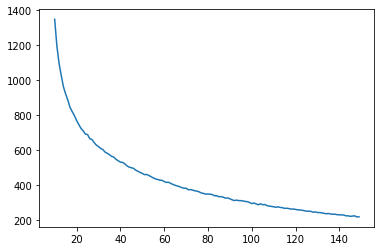

In [ ]:
plt.plot(range(10, 150), scores)

Με βάση το παραπάνω διάγραμμα και μερικές δοκιμές επιλέγουμε τιμή **clusters = 35**.

In [ ]:
algo = KMeans(n_clusters=35)
som.cluster(algorithm=algo)

Τέλος, αποθηκεύουμε το SOM ώστε να διατηρηθούν τα συμπεράσματα, αφού η αρχικοποίηση και το clustering είναι στοχαστικές διαδικασίες.

In [ ]:
# Αποθήκευση του som
joblib.dump(som, './som_clusters_final.pkl')

['./drive/My Drive/som_clusters_final.pkl']

Για τη διατήρηση των αποτελεσμάτων φορτώνουμε τον ήδη δημιουργημένο SOM με διαστάσεις 25x25 και 40 clusters.

In [ ]:
som = joblib.load('./som_clusters_final.pkl')

## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιούμε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)`.

Σε ένα επόμενο markdown παράθυρο εμφανίζουμε τη μεταβλητή `clusters`, για να είναι σε πιο εμφανίσιμη μορφή.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` με όρισμα return counts  εκτυπώνουμε τις ετικέτες των clusters  και τον αριθμό των νευρώνων σε κάθε cluster, με αύξουσα σειρά ως προς τον αριθμό των νευρώνων. 

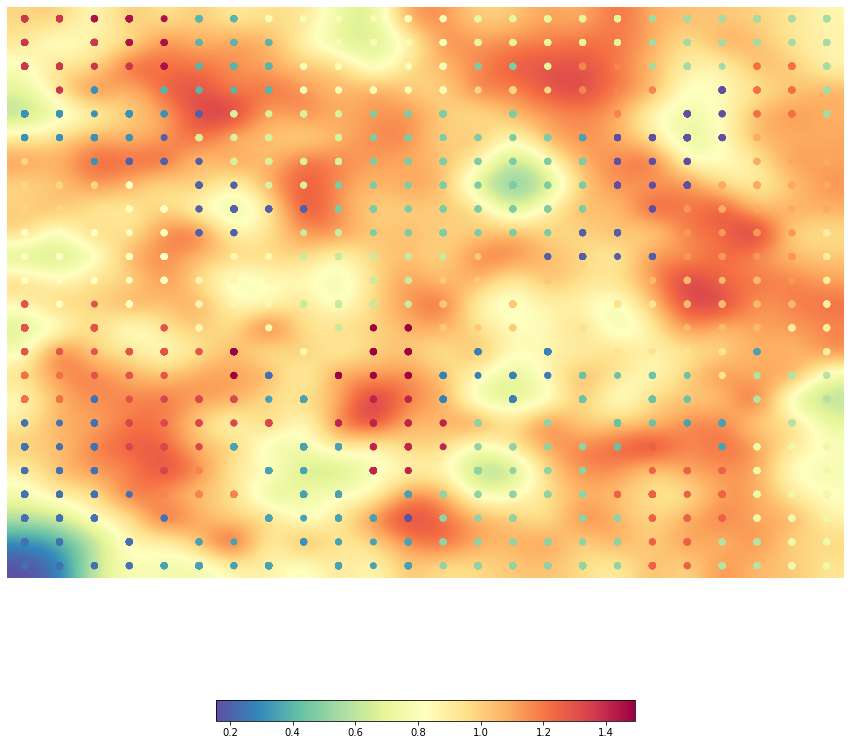

Clusters Sorted by increasing number of neurons : 

Cluster              Neurons             
------------------------------------------------------------
33                   6                   
19                   8                   
21                   10                  
25                   10                  
27                   10                  
31                   10                  
14                   11                  
23                   11                  
32                   11                  
6                    12                  
7                    12                  
22                   12                  
26                   12                  
11                   13                  
20                   13                  
30                   13                  
34                   13                  
3                    14                  
4                    14                  
18                   14                  
24   

In [ ]:
som.view_umatrix(figsize=(15,15), bestmatches=True, colorbar = True)

print("Clusters Sorted by increasing number of neurons : ")
clusters_sorted_index, counts = np.unique(som.clusters, return_counts = True)

sorted_clusters = [x for _,x in sorted(zip(counts,clusters_sorted_index))]
counts = sorted(counts)
print('\n{:<20} {:<20}'.format('Cluster', 'Neurons'))
print('-'*60)
for i in range(len(sorted_clusters)):
    print('{:<20} {:<20}'.format(sorted_clusters[i], counts[i]))



Clusters : 

    [31 31 33 33 33  6  6 16 16 16 16 16 16 14 14 14 14 14 10 10 10 10 10 10]	
    [31 31 31 33 33  6  6  6 16 16 16 16 16 14 14 14 14 14 10 10 10 10 10 10]
    [31 31 31 31 33  6  6  6 16 16 16 16 16  8  8 14 26 26 10 10 10 27 27 10]		
    [ 4 31  4  4  6  6  6  6 16 16 16 16 16 21 21 21 26 26 26  0  0 27 27 10]   
    [ 4  4  4  4  4  1 13 13 13 13  8  8  8  8  8  8 26 26  0  0  0 27 27 10]		
    [ 4  4  4  4  1 13 13 13 13 13  8  8  8  8  8  8  5  0  0  0  0 24 24 24]		
    [21 21  4  1  1  1 13 13 13 13  8  8  8  8  8  8  8  0  0  0  0 24 24 24]		
    [21 21 21 17  1  1  1 13 13  8  8  8  8  8  8  8  8  0  0  0 24 24 24 24]			
    [21 21 17 17 17  1  1  1  1  8  8  8  8  8  8  8  8  8  0 25 24 24 24 24]			
    [17 17 17 17 17  1  1  1 12 12  8  8  8  8  8  8  1  1  1 25 25 25 25 19]			
    [17 17 17 17 17 17 18 18 12 12 12 12 12 22  8  1  1  1  1 25 25 25 25 19]			
    [17 17 17 17 17 18 18 18 18 12 12 12 22 22 22 22 20 20 23 23 23 23 25 19]			
    [29 17 29 17 17 18 18 18 12 12 12 12 22 22 22 22 20 20 20 23 23 23 23 19]			
    [29 29 29 29 29 18 18 18 18 12 34 34 22 22 22  3 20 20 20 23 23 23 19 19]			
    [29 29 29 29 29 29 34 34 18 34 34 34 34  3  3  3  3 20 20 20 20  5 19 19]			
    [27 27 29 29 29 30 34  2 34 34 34 34  3  3  3  3  7  7  7  7 20 11 11 11]			
    [27 27  2 29 30 30 30  5  5  5 32 32  3  3  3  3  7  7  7  7  5 11 11 11]			
    [ 2  2  2 30 30 30 30 30  5 32 32 32 32  9  3  9  7  7  7  5  5 11 11 11]			
    [ 2  2  2 30 30 30  5  5  5  5 32 32 32  9  9  9  9  7 28 28  5 15 15 15]			
    [ 2  2  2  2 30 26  5  5  5  5 32 32  9  9  9  9  9  9 28 28 28 15 15 15]			
    [ 2  2  2  2 26 26 26  5  5  5  5  5  9  9  9  9  9 28 28 28 28 15 15 15]			
    [ 2  2  2  2  2 26  5  5  5  5  5  0  9  9  9  9  9  9 28 28 28 15 15 15]			
    [ 2  2  2  2  2  5  5  5  4  5  5  5  9  9  9  9  9  9 28 28 11 11 15 15]			
    [ 2  2  2  2  5  5  5  5  5  5  5  5  9  9  9  9  9  9 28 28 11 11 15 15]

## Σημασιολογική ερμηνεία των clusters

Για να μελετήσουμε τη σημασιολογία των clusters, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης τους. Για κάθε cluster, βρίσκουμε τους νευρώνες οι οποίοι έχουν ανατεθεί σε αυτόν από τον αλγόριθμο k-means. Για τους νευρώνες αυτούς, βρίσκουμε τις ταινίες οι οποίες έχουν ανατεθεί σε αυτούς. Παρακολουθούμε τα ποσοστά των ειδών των ταινιών σε κάθε clusters και θέλουμε να παρατηρήσουμε patterns σε αυτά

Αρχικά, δημιουργούμε τη συνάρτηση `print_categories_stats(ids, siz = 0)` η οποία δέχεται ως είσοδο μια λίστα ταινιών και μια παράμετρο `siz` την οποία χρησιμοποιούμε στο τέλος. Για κάθε id, βρίσκουμε τις κατηγορίες της ταινίας που αντιστοιχεί σε αυτό και τις προσθέτουμε σε μία λίστα cats. Στη συνέχεια, μέσω της `np.unique` βρίσκουμε τις μοναδικές τιμές τους, ενώ με την επιλογή `return_counts` διατηρούμε και το πλήθος τους. Ταξινομούμε τις κατηγορίες με βάση τη συχνότητα εμφάνισης τους και εμφανίζουμε το ποσοστό τους ως προς το σύνολο των *μοναδικών κατηγοριών*. Το τελευταίο έχει ως αποτέλεσμα να μην αθροίζονται τα ποσοστά στο 100%, αφού μπορεί για παράδειγμα πολλές ταινίες να έχουν κοινά είδη. Με την παράμετρο `siz` μπορούμε να επιλέξουμε να τυπώσουμε μόνο έναν αριθμό από τις κορυφαίες σε συχνότητα ταινίες.

In [ ]:
def print_categories_stats(ids, siz = None):
  cats = []
  # Finding categories
  for id in ids:
    categ = categories[id][0]
    temp = categ.split(',')
    temp = [t.replace('"','') for t in temp]
    temp = [t.lstrip() for t in temp]
    cats.extend(temp)
  
  # Keeping only unique categories
  cats_unique, count = np.unique(cats, return_counts = True)
  total_categories = len(ids)

  # Sorting by number of occurences
  sorted_cats = [x for _,x in sorted(zip(count, cats_unique), reverse=True)]
  count = sorted(count, reverse = True)
  print('\n{:<40} {:<20} {:<20}'.format('Category', 'Occurences', 'Percentage'))
  print('-'*60)
  if(siz == None):
    r = len(sorted_cats)
  else:
    r = siz
  for i in range(r):
    print('{:<40} {:<20}'.format(sorted_cats[i], count[i]),  "{0:.2f} %".format(count[i]*100.0/total_categories))

In [ ]:
# printing stats for all films in dataset

id = [i for i in range(5000)]
print_categories_stats(id)


Category                                 Occurences           Percentage          
------------------------------------------------------------
Drama                                    2242                 44.84 %
Comedy                                   1290                 25.80 %
Thriller                                 787                  15.74 %
Action                                   765                  15.30 %
Romance Film                             747                  14.94 %
World cinema                             618                  12.36 %
Crime Fiction                            510                  10.20 %
Horror                                   503                  10.06 %
Black-and-white                          473                  9.46 %
Action/Adventure                         439                  8.78 %
Adventure                                422                  8.44 %
Short Film                               419                  8.38 %
Indie              

Από το παραπάνω παρατηρούμε ότι υπάρχουν κάποια κυρίαρχα είδη, κυρίως το 'Drama', στο οποίο ανήκουν σχεδόν οι μισές ταινίες του dataset. Αυτό θα έχει σημασία στα επόμενα ερωτήματα.



Στη συνέχεια, ορίζουμε τη συνάρτηση `print_cluster_neurons_movies_report(curr_cluster)`, η οποία δέχεται ως όρισμα ένα cluster και υπολογίζει τους νευρώνες οι οποίοι αντιστοιχούν στον cluster, στον πίνακα `ubmus`. Για να το πετύχουμε αυτό βρίσκουμε αρχικά τις συντεταγμένες των bmus που αντιστοιχούν στον cluster και τα αντιστοιχούμε σε συντεταγμένες μέσω της `np.column_stack()`. Στη συνέχεια για κάθε συντεταγμένη ελέγχουμε όλα τα στοιχεία του πίνακα `ubmus` και αν οι συντεταγμένες του `ubmus[index]` ισούται με τη συντεταγμένη που ψάχνουμε, προσθέτουμε το νευρώνα αυτό σε μία λίστα `neurons_list` την οποία επιστρέφουμε.

In [ ]:
def print_cluster_neurons_movies_report(curr_cluster):
  x,y = np.where(som.clusters == curr_cluster)
  coords = np.column_stack([x,y])

  neurons_list = []

  for i in coords:
    for index in range(len(ubmus)):
      if(np.array_equal(ubmus[index],i)):
        neurons_list.append(index)
        break
  return neurons_list


In [ ]:
print_cluster_neurons_movies_report(0)

[83, 102, 103, 104, 122, 123, 124, 125, 144, 145, 146, 164, 165, 180, 450]

Τέλος, ορίζουμε τη συνάρτηση `neuron_movies_report(curr_cluster, moviesToPrint = 0)`. Η συνάρτηση αυτή λαμβάνει τον αριθμό ενός cluster και μια παράμετρο moviesToPrint. Αρχικά, λαμβάνουμε τους νευρώνες του cluster μέσω της `print_cluster_neurons_movies_report`. Για κάθε νευρώνα, βρίσκουμε τα id των ταινιών τα οποία αντιστιχοίζονται σε αυτόν τον νευρώνα, και για τις ταινίες αυτές καλούμε τη συνάρτηση `print_categories_stats` για να λάβουμε στατιστικά σχετικά με τα είδη.

In [ ]:
def neuron_movies_report(curr_cluster, moviesToPrint = None):
    neurons = print_cluster_neurons_movies_report(curr_cluster)

    movies_list = []

    for index in neurons:
        for movie_id in range(len(final_set)):
            if(np.array_equal(ubmus[index],bmus[movie_id])):
                movies_list.append(movie_id)
    print(f"Cluster {curr_cluster} contains {len(movies_list)} movies.")
    print_categories_stats(movies_list, siz = moviesToPrint)
    return movies_list

Εκτελούμε την τελευταία συνάρτηση για κάθε νευρώνα και εμφανίζουμε τις 3 κορυφαίες κατηγορίες που εμφανίζονται σε αυτόν.

In [ ]:
for i in range(35):
  alist = neuron_movies_report(curr_cluster = i, moviesToPrint = 3)
  print ('='*60)

Cluster 0 contains 159 movies.

Category                                 Occurences           Percentage          
------------------------------------------------------------
War film                                 63                   39.62 %
Drama                                    60                   37.74 %
Western                                  51                   32.08 %
Cluster 1 contains 112 movies.

Category                                 Occurences           Percentage          
------------------------------------------------------------
Comedy                                   74                   66.07 %
Indie                                    64                   57.14 %
Drama                                    53                   47.32 %
Cluster 2 contains 263 movies.

Category                                 Occurences           Percentage          
------------------------------------------------------------
Action                                   250        

Σε μια πιο συνοπτική μορφή εμφανίζουμε μόνο το κορυφαίο είδος ταινιών του κάθε cluster: 

```
Cluster 0: War Film 
Cluster 1: Comedy         
Cluster 2: Action                               
Cluster 3: Short Film
Cluster 4: Romance Film
Cluster 5: Adventure   
Cluster 6: Drama  
Cluster 7: Short Film 
Cluster 8: Black-and-white   
Cluster 9: Family Film
Cluster 10: Drama
Cluster 11: Horror      
Cluster 12: Comedy
Cluster 13: Drama
Cluster 14: Drama
Cluster 15: Thriller
Cluster 16: World cinema
Cluster 17: Comedy
Cluster 18: Comedy
Cluster 19: Science Fiction
Cluster 20: Horror
Cluster 21: Drama
Cluster 22: Short Film
Cluster 23: Horror
Cluster 24: Comedy film
Cluster 25: Documentary
Cluster 26: Action
Cluster 27: Drama
Cluster 28: Thriller   
Cluster 29: Comedy
Cluster 30: Action
Cluster 31: Drama 
Cluster 32: Comedy 
Cluster 33: Romance Film   
Cluster 34: Comedy


```

## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM
Τυπώνοντας τη μορφη του χάρτη καθώς και τις τρείς πρώτες κατηγορίες που αναγνωρίζονατι σε κάθε cluster μπορούμε να λάβουμε διάφορα συμπεράσματα. Αρχικά παρατηρούμε ότι σχεδόν όλοι οι clusters έχουν μεγάλα ποσοστά για κάποιο είδος ταινίας (πολλές φορές 100%, που σημαίνει πως όλες οι ταινίες που αντιστιχοίστηκαν στον cluster περιέχουν το αντίστοιχο είδος). Επομένως το μέγεθος του χάρτη και ο αριθμός των clusters ήταν κατάλληλα επιλεγμένος.


### Δεδομένα με μεγαλύτερη πυκνότητα πιθανότητας 

Αρχικά, παρατηρούμε ότι ταινίες με μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου εμφανίζονται σε περισσότερους clusters. Για παράδειγμα, η κατηγορία **Drama** εμφανίζεται στο dataset σε ~44% των ταινιών, διπλάσιο ποσοστό της δευτερης πιο συχνής. Οι clusters που αντιστοιχούν σε ταινίες **Drama** είναι οι `6, 10, 13, 14, 21, 27, 31`. Οι clusters αυτοί βρίσκονται σε πολλές περιοχές του χάρτη, αφού για παράδειγμα ο cluster `31` βρίσκεται στο πάνω αριστερά τμήμα, ο cluster `13` βρίσκεται στο κέντρο, ενώ ο cluster `10` βρίσκεται στο πάνω δεξιά τμήμα.

Αντίστοιχα, ένα είδος με μικρό ποσοστό αναπαράστασης στο αρχικό dataset, όπως το **War Film** με μικρή αναπαράσταση εμφανίζεται μόνο στον cluster `0`.




### Μακρινά πρότυπα εισόδου σε απομακρυσμένα σημεία

Εμφανίζονται μακρινά πρότυπα εισόδου, τα οποία εμφανίζονται και σε μακρινά σημεία του χάρτη.

Για παράδειγμα, οι clusters `4 ,33` που αναγνωρίζουν ταινίες τύπου **Romance** βρίσκονται κυρίως στο άνω αριστερά τμήμα του χάρτη, ενώ οι clusters ταινιών **Thriller**  `15, 28` βρίσκονται στα αριστερά και κάτω άκρα του χάρτη.

### Κοντινά πρότυπα εισόδου

Παρατηρούμε αρκετά παραδείγματα κοντινών προτύπων εισόδου που απεικονίζονται κοντά στο χάρτη.

1. Τα clusters στο άνω αριστερά τμήμα του χάρτη `31, 33, 4, 6, 21` περιέχουν είδη **Romance** και **Drama**, τα οποία έχουν συνάφεια.

2. Τα clusters `15, 11, 28, 23` βρίσκονται επίσης κοντά στον χάρτη στο κάτω δεξιά τμήμα και περιλαμβάνουν τα είδη **Horror** και **Thriller**.

3. Οι clusters `2, 30, 5, 26` βρίσκονται κοντά στο κέντρο του χάρτη και αντιστοιχοίζονται στα είδη **Action** και **Adventure**, τα οποία είναι πολύ συναφή.


Μπορούμε επιπλέον να παρατηρήσουμε σημεία του χάρτη με σαφή χαρακτηριστικά.

1. Παρατηρούμε οτι τα clusters στο κατω αριστερά τεταρτημοριο του χάρτη κατηγοριοπουούν ταινίες με βασική κατηγορία το **Action** ή το **Adventure** σε ποσοστό μέχρι και 100% Ενδεικτικά αναφέρουμε του clusters `2, 30, 5, 26` οι οποίοι συνορεύουν μεταξύ τους και καλύπτουν την ίδια ευρεία περιοχή.

2. Το κατω δεξια τεταρτημόριο αποτελείται κυρίως απο clusters με βασικα χαρακτηριστικα το **Thriller** και το **Horror** και αν και αποτελουν ξεχωριστη ομάδα παρουσιάζουν μια μικρή γειτνίαση με την προηγούμενη ομάδα. Ενδεικτικά αναφέρουμε τους clusters `15, 11, 28, 23`.

3. Στο κέντρο του χάρτη όπως αναφέρθηκε υπάρχει ένα σύνολο clusters `2, 30, 5, 26` που αντιστοιχοίζονται στα είδη **Action** και **Adventure**.

4. Στο πάνω δεξιά κομματι του χαρτη είναι μαζεμένοι ολοι οι clusters Που αποτελούν ενα συνοθύλευμα απο τα υπολοιπα είδη που μπορεί να συναντήσει κανείς χωρίς απαραίτητα να έχουν κάποια μεγάλη σχέση μεταξύ τους. Συγκεκριμένα εμφανίζονται με σημαντικά ποσοστά κατηγορίες όπως **Drama**, **War Film**, **Documentary** , **World-cinema** Ενδεικτικά αναφέρουμε εδώ τους clusters `10, 27,`6, 0, 14, 26`.

### Clusters με υποείδη

Παρατηρούμε διάφορους clusters που περιέχουν υποείδη του κυρίαρχου είδους. Τα πιο χαρακτηριστικά παραδείγματα είναι:

*   *Cluster 3* : Έχουμε ποσοστό 100% σε **Short Film**, αλλά παρατηρούμε υψηλά ποσοστά σε **Comedy** και **Animation**, υποδυκνείοντας ταινίες κινουμένων σχεδίων μικρού μήκους.
*   *Cluster 6*: Έχουμε ως κύρια κατηγορία **Drama**, αλλά οι μισές ταινίες του cluster είναι **Musical**.
*    *Cluster 8*: Μετά το κυρίαρχο είδος **Black-and-white**, έχουμε πολλές ταινίες τύπου **Silent film**.
*    *Cluster 15*: Παρατηρούμε μεγάλη πληθηκότητα του **Thriller** και του **Mystery** με τρίτο σε ποσοστό είδος το **Crime Thriller**.
*    *Cluster 16*: Εδώ έχουμε ταινίες **World Cinema**, και πιο συγκεκριμένα **Bollywood** σε μεγάλα ποσοστά.
*    *Cluster 11*: Με πρώτο είδος το **Horror**, έχουμε μεγάλα ποσοστά εμφάνισης **Slasher**.
*    *Cluster 27*: Έχουμε μεγάλα ποσοστά στα υποείδη του **Drama**: **Martial Arts Film** και **Chinese Movies**.

### Clusters με μη σαφή χαρακτηριστικά

Υπάρχουν clusters με μη σαφή χαρακτηριστικά. Έχουμε ως πιο έντονο παράδειγμα το cluster `25`, το οποίο με 115 ταινίες είναι ένα μεσαίου μεγέθους cluster, το οποίο όμως δεν έχει κάποιο είδος να ξεχωρίζει. Συγκεκριμένα, έχουμε **Documentary** με ποσοστό 39.13 %, **Fantasy** με 13.04 % και **Comedy-drama** με 13.04 %. Τα είδη αυτά δεν παρουσιάζουν κάποια άμεση συνάφεια και τα ποσοστά είναι αρκετά μικρά.

Ένα άλλο παράδειγμα είναι ο cluster `20` με ποσοστά **Horror** 54.39 %, **Documentary** με 47.37 % και **Short Film** με 29.82 %. Τα ποσοστά αυτά είναι πάλι σχετικά μικρά σε σχέση με άλλα clusters, ενώ πάλι τα ήδη δε φαίνεται να σχετίζονται άμεσα.

### Clusters χωρίς τοπολογική συνάφεια με γύρω περιοχές

Εμφανίζονται λίγα clusters τα οποία δεν φαίνεται να έχουν συνάφεια με τα κοντινά τους clusters. Για παράδειγμα, το cluster `9` που έχει ως κύρια κατηγορία τις ταινίες **Family Film** συνορεύει με αρκετές ταινίες τύπου **Thriller** ή **Horror**. Μπορούμε να βρούμε περισσότερα παραδείγματα αν ψάξουμε συγκεκριμένα 2 clusters μόνο οι οποίοι συνορεύουν. Ένα τέτοιο παράδειγμα είναι ο cluster `1` που αντιστοιχεί κυρίως σε ταινίες **Comedy** συνορεύει με τον cluster `20` που αντιστοιχεί κυρίως σε ταινίες τύπου **Horror**.

Τα παραπάνω ήταν αναμεννόμενο να προκύψουν, λόγω τόσο της μείωσης της διαστατικότητας όσο και του γεγονότος ότι και σε περισσότερες διαστάσεις δεν υπάρχει σαφής τοπολογία για τα κινηματογραφικά είδη.

### Clusters ιδιαίτερου ενδιαφέροντος

Τελειώνοντας, θα καταγράψουμε τα clusters που θεωρούμε πως έχουν κάποιο ιδιαίτερο ενδιαφέρον. Μερικά αναφέρθηκαν ήδη σε προηγούμενες παρατηρήσεις.



Αρχικά έχουμε τους clusters οι οποίοι πετυχαίνουν ποσοστό > 80% και στις 3 πρώτες κατηγορίες. Σε αυτή την περίπτωση οι clusters είναι ιδιαίτερα εξειδικευμένοι, καθώς όλες σχεδόν οι τανίες τους περιέχουν τα κοινά είδη:
  1.    Cluster 4: *Romantic Drama, Romance Film, Drama*
  2.    Cluster 22 : *Short Film, Black-and-white, Silent Film*
  3.    Cluster 31 : *Drama, Romance Film, Romantic Drama*

Ενδιαφέρον παρουσιάζουν και οι clusters με κυρίαρχα ιδιαίτερα είδη, τα οποία δε βλέπουμε σε άλλους clusters. Τέτοιοι είναι ο cluster `0` με **War film**, ο cluster `8` με **Black-and-white**, o cluster `25` με **Documentary**, ο cluster `19` με **Science Fiction** και ο cluster `9` με **Family Film**.

Τέλος, έχουμε τους clusters οι οποίοι περιέχουν υπο-είδη των κυρίαρχων ειδών. Μερικοί αναφέρθηκαν ήδη, συγκεκριμένα οι `3, 6, 8, 11, 15, 16, 27`, αλλά έχουμε επιπλέον τους `5` με σημαντικό ποσοστό **War Films**, `26` με αρκετές ταινίες **Period Piece**, `12` με μερικές ταινίες **Slapstick** και `18`, οπού περιέχονται **Satire**.